In [1]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from utils import fft_denoise, wavelet_denoise, compute_metrics
from datasets import ECGDataset
from models import *

model_dict = {
    "UNet": UNet,
    "ACDAE": ACDAE,
    "Seq2Seq2": Seq2Seq2,
    "ralenet": ralenet,
    "AGSUNet": AGSUNet,
    "WT": wavelet_denoise,
    "FFT": fft_denoise,
}


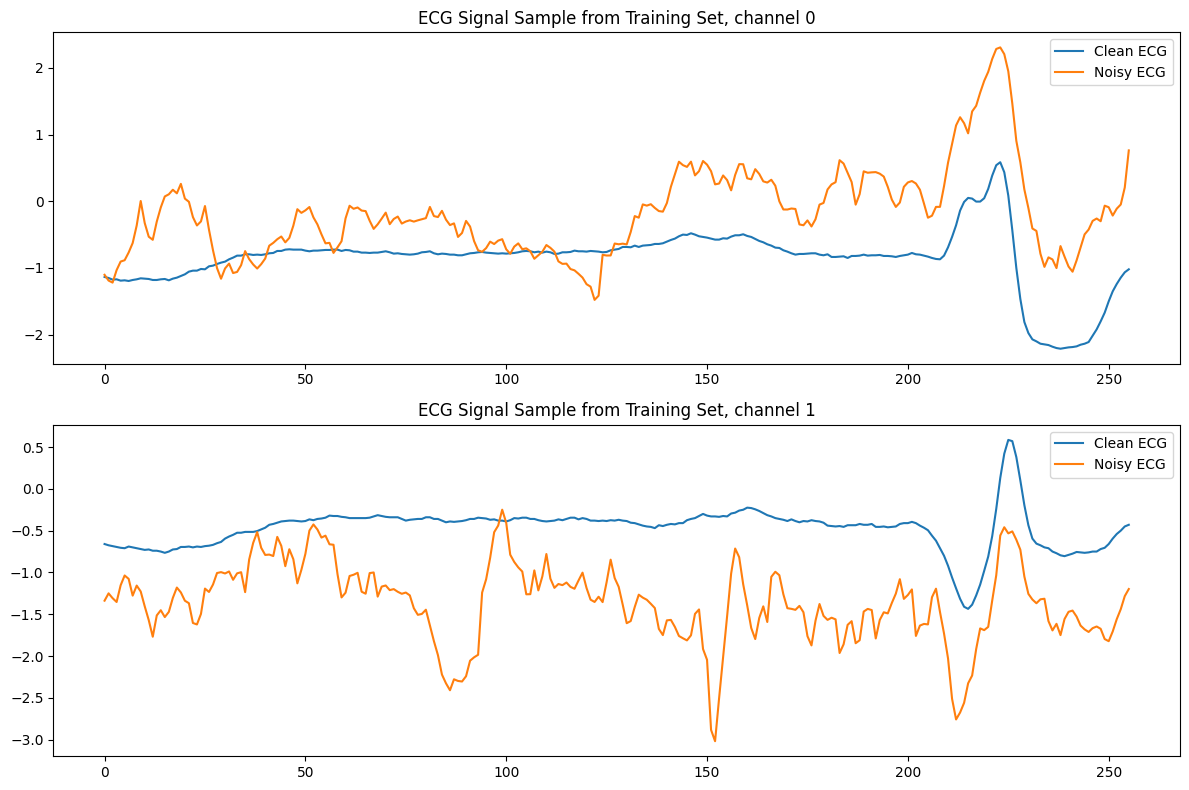

In [2]:
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
	split="test",
	noise_type=noise_type,
	snr_db=snr_db,
	split_dir="./data_split",
)
idx = np.random.randint(0, len(dataset) - 1)
noisy, clean = dataset[idx]

mean, std = dataset.get_stats()
ori_mean = mean.squeeze(0).permute(1, 0)
ori_std = std.squeeze(0).permute(1, 0)

ori_noisy = noisy * ori_std + ori_mean


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(clean[0].numpy(), label="Clean ECG")
plt.plot(ori_noisy[0].numpy(), label="Noisy ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 0")

plt.subplot(2, 1, 2)
plt.plot(clean[1].numpy(), label="Clean ECG")
plt.plot(ori_noisy[1].numpy(), label="Noisy ECG")
plt.legend()
plt.title("ECG Signal Sample from Training Set, channel 1")

plt.tight_layout()
plt.show()

FFT Denoising Metrics: {'RMSE': 0.9156531095504761, 'SNR': -1.348982334136963}


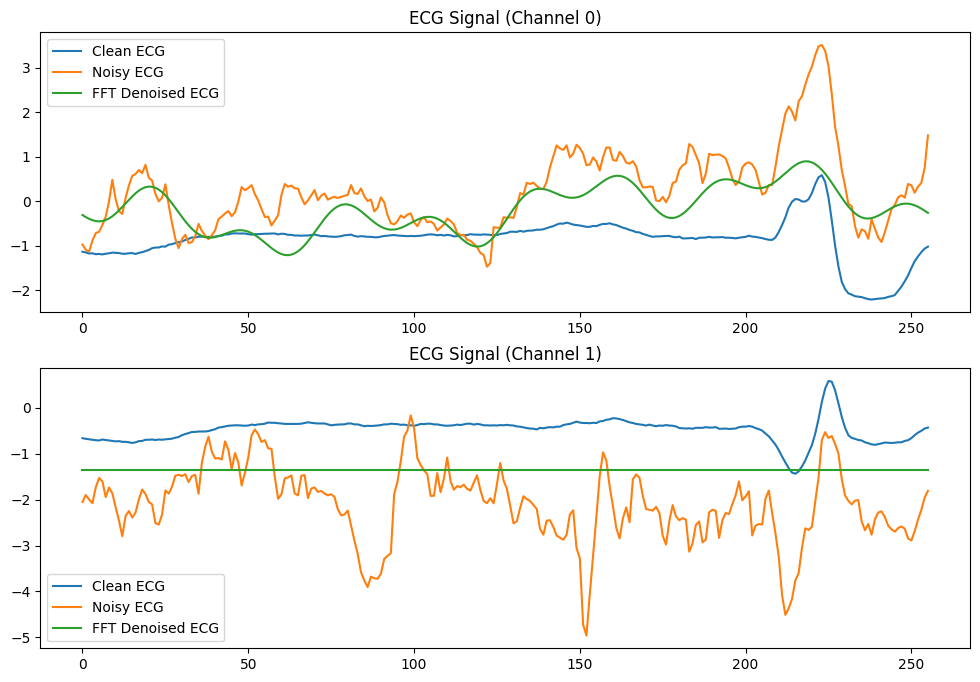

In [14]:
model_name = "FFT"

if model_name not in ["WT", "FFT"]:
    model = model_dict[model_name]()
    model.load_state_dict(torch.load(f"./checkpoints/best_{model_name}_{noise_type}_snr_{snr_db}.pth", map_location="cpu"))
    model.eval()

    with torch.no_grad():
        noisy_input = torch.tensor(noisy)
        noisy_input = noisy_input.unsqueeze(0)  # Add batch dimension
        denoised_output = model(noisy_input)

    clean_metric = torch.tensor(clean).unsqueeze(0)  # Add batch dimension
    metrics_res = compute_metrics(denoised_output, clean_metric, mean, std)
    print(f"{model_name} Denoising Metrics:", metrics_res)

    denoised_output = denoised_output.squeeze(0)  # Remove batch dimension

    mean = np.array(mean).squeeze()
    std = np.array(std).squeeze()
    print(mean.shape, std.shape)

    for i in range(denoised_output.shape[0]):
        denoised_output[i] = denoised_output[i] * std[i] + mean[i]
        noisy[i] = noisy[i] * std[i] + mean[i]

else:
    if model_name == "WT":
        denoised_output = wavelet_denoise(ori_noisy.numpy(), threshold=0.5)
    elif model_name == "FFT":
        denoised_output = fft_denoise(ori_noisy.numpy(), threshold=0.5)
    
    denoised_output = torch.tensor(denoised_output)

    clean_metric = torch.tensor(clean).unsqueeze(0)  # Add batch dimension
    metrics_res = compute_metrics(denoised_output.unsqueeze(0), clean_metric)
    print(f"{model_name} Denoising Metrics:", metrics_res)


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(clean[0], label="Clean ECG")
plt.plot(noisy[0], label="Noisy ECG")
plt.plot(denoised_output[0], label=f"{model_name} Denoised ECG")
plt.title("ECG Signal (Channel 0)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(clean[1], label="Clean ECG")
plt.plot(noisy[1], label="Noisy ECG")
plt.plot(denoised_output[1], label=f"{model_name} Denoised ECG")
plt.title("ECG Signal (Channel 1)")
plt.legend()

plt.show()